## Problem Description

Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while Cinematch is doing pretty well, it can always be made better.

Now there are a lot of interesting alternative approaches to how Cinematch works that netflix haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business.

Credits: https://www.netflixprize.com/rules.html

## Problem Statement

Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training data set. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.)

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 2

# this is just to know how much time will it take to run this entire ipython notebook 
from pathlib2 import Path
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('nbagg')
from modules.custom_transformers import *
from surprise import BaselineOnly, KNNBaseline, SVD, SVDpp
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import log_loss,mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import KFold
from itertools import product
from math import sqrt


from sklearn.pipeline import Pipeline, FeatureUnion
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix

from surprise import Reader, Dataset

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 2 seconds


## Data Loading (convert text file to user, movie, rating csv format)

In [2]:
datapath = Path()/'download'/'training_set'

start = datetime.now()
if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data.csv', mode='w')
    
    row = list()
    files= datapath.iterdir()
    
    for file in tqdm(files): # iterate text files 
        with open(file) as f:
            for line in f: 
                #del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
    data.close()
print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.000184


In [3]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')


creating the dataframe from data.csv file..
Done.

Sorting the dataframe by date..
Done..


In [5]:
df.to_csv('data_sorted.csv',header = False)
df.head()

,movie,user,rating,date
43633754,16465,510180,3,1999-11-11
36109973,8651,510180,2,1999-11-11
18155326,3870,510180,2,1999-11-11
60735152,5571,510180,4,1999-11-11
39446212,8357,510180,4,1999-11-11


In [5]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [6]:
# check for nulls

# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


In [14]:
# check for duplicates

dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


## Basic Statistics 

In [1]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------


NameError: name 'df' is not defined

 ## Spliting data into Train and Test (80:20) [Time based splitting]

Since Date is available it is available always good to split time based as model can better predict future time  

In [ ]:
if not os.path.isfile('train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

### Basic Statistics in Train data

In [10]:
# movies = train_df.movie.value_counts()
# users = train_df.user.value_counts()
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 405022
Total No of movies  : 17424


### Basic Statistics in Test data

In [11]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 20096102
Total No of Users   : 349328
Total No of movies  : 17757


##  Exploratory Data Analysis on Train data

In [12]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

###  Distribution of ratings

<IPython.core.display.Javascript object>


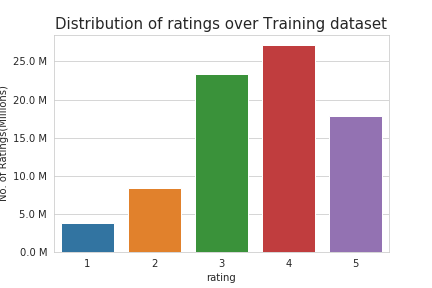

In [19]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

### extract DOW from date

In [16]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

train_df['day_of_week'] = train_df.date.dt.day_name()

train_df.tail()

,movie,user,rating,date,day_of_week
80384400,9314,671870,4,2005-08-08,Monday
80384401,7728,343554,1,2005-08-08,Monday
80384402,13074,47058,4,2005-08-08,Monday
80384403,13074,1317996,3,2005-08-08,Monday
80384404,2452,1302514,3,2005-08-08,Monday


### Number of Ratings per a month

<IPython.core.display.Javascript object>


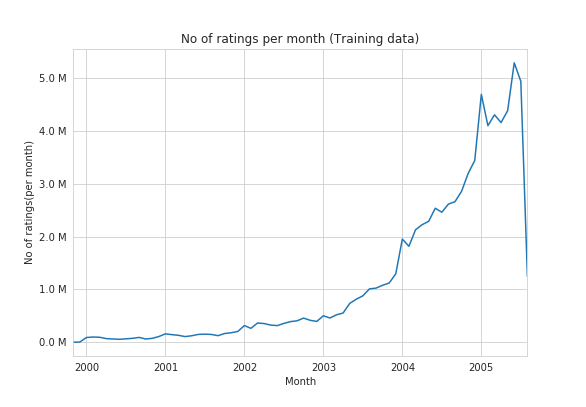

In [20]:
plt.figure()
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

It can be observed that after 2003 the popularity of Netflix sky rocketed 

In [21]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user
305344     17111
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

higest rating by user in 17111 which is insanely high

<IPython.core.display.Javascript object>


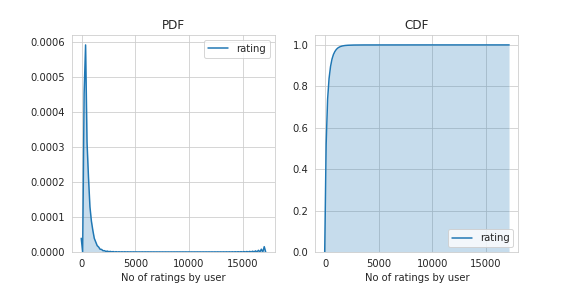

In [22]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

We see left skewed plot indicating lot of users have rated less than few hundreds

In [24]:
no_of_rated_movies_per_user.describe()

count    405022.000000
mean        198.469231
std         290.801514
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17111.000000
Name: rating, dtype: float64

50% of users have no of ratings less than 89. There significant gap between 75% qunatile and max value 

In [25]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<IPython.core.display.Javascript object>


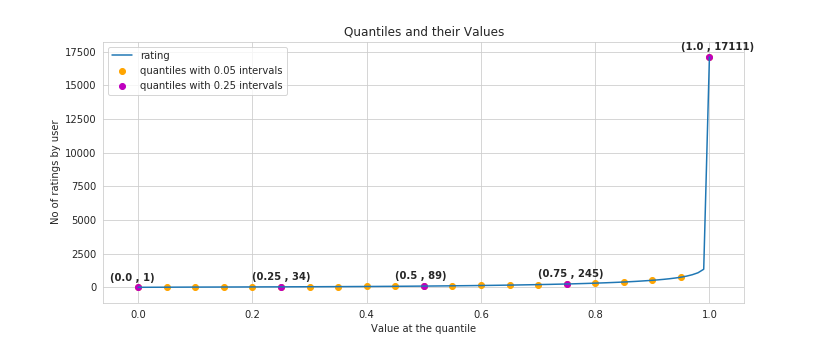

In [26]:
plt.figure()
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

till 95% quantile is within a range after that we see unresonable values,

In [27]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 749)) )


 No of ratings at last 5 percentile : 20303



##  Analysis of ratings of a movie given by a user 

<IPython.core.display.Javascript object>


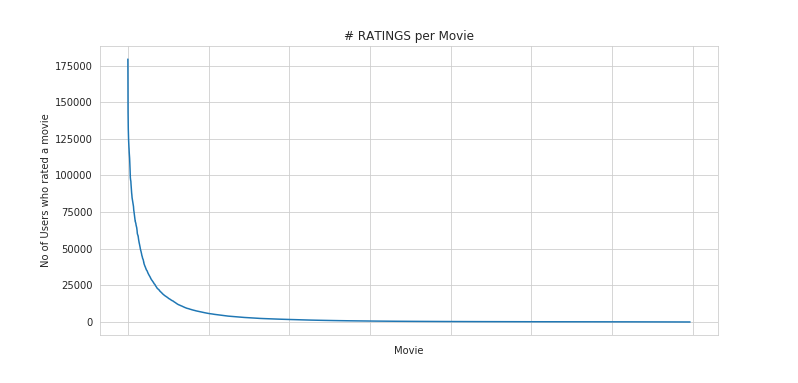

In [29]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

- There are some movies (which are very popular) which are rated by huge number of users.

- But most of the movies(like 90%) got some hundereds of ratings.

### Number of ratings on each day of the week

<IPython.core.display.Javascript object>


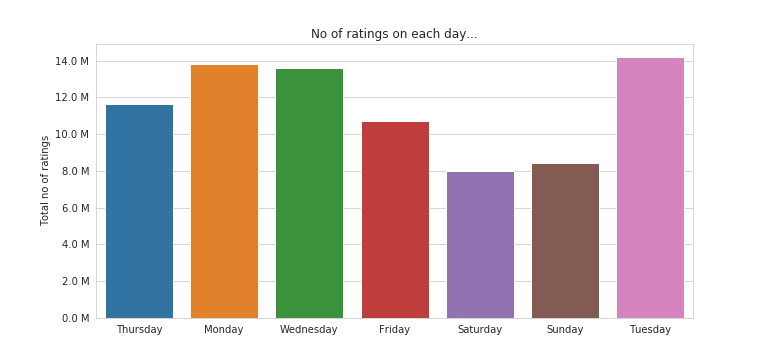

In [30]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

- no of Ratings given are less on weekends 
- Tuesday has highest rating given

<IPython.core.display.Javascript object>


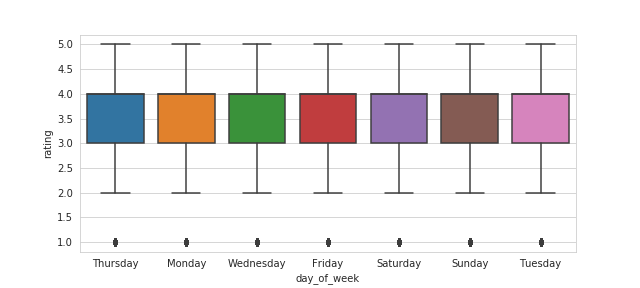

0:00:11.936783


In [32]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now() - start)

- DOW is not such a useful measure

In [31]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 AVerage ratings
------------------------------
day_of_week
Friday       3.585274
Monday       3.577114
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




## Creating a Sparse matrix (User - Movie rating  matrix)

### For Train data

In [5]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:05.162035


#### The Sparsity of Train Sparse Matrix

In [9]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.8292709259195 % 


Very Sparse 

#### Creating sparse matrix from test data frame

In [6]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
    
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:02.197296


#### The Sparsity of Test data Matrix

In [11]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95731772988694 % 


# Featurization

### Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [7]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users): # for both users and movies
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

### Global Average

In [12]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.5828673360212098}

Roughly overall avg user rating is around 3.58

###  finding average rating per user

In [15]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.3891625615763545


Average rating of user tells how critic of movies He is lean or very Critic

### finding average rating per movie

In [16]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])


 AVerage rating of movie 15 : 3.3038461538461537


Tells How good is the movie

### Distribution of Avg.Ratings of Users & Movies

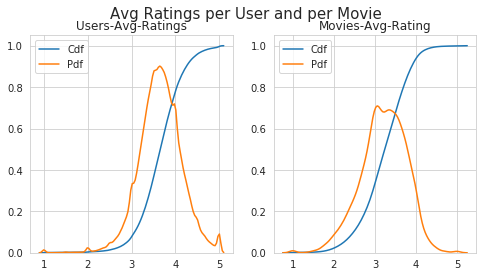

0:00:24.861827


In [8]:
start = datetime.now()
# draw pdfs for average rating per user and average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('Users-Avg-Ratings')
# get the list of average user ratings from the averages dictionary..
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')

ax2.set_title('Movies-Avg-Rating')
# get the list of movie_average_ratings from the dictionary..
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')

plt.show()
print(datetime.now() - start)

## Cold Start problem

### Cold Start problem with Users

- Some users and movies joined during test period hence have no rating history (not available in Train data)

In [14]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 405022

No of Users that didn't appear in train data: 75167(15.65 %) 
 


15.65 is fairly significant number

###  Cold Start problem with Movies

In [15]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 17770

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: 346(1.95 %) 
 


## Computing Similarity matrices 

### Computing User-User Similarity matrix

Remember we have 405k users and Rating vector for each user would be 17k (no of movies) comuting for each user or movie would take days together takes huge space[405k*405k].It is better to compute only when required and store users with top similarity scores for a particular user 

### Computing Movie-Movie Similarity matrix 

In case of Movie Movie similarity matrix computtaion is efficient both in terms of space and time complexity

In [7]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It is there, We will get it.
Done ...
It's a  (17771, 17771)  dimensional matrix
0:00:50.594473


- Even though we have similarity measure of each movie, with all other movies, We generally don't care much about least similar movies.
- Most of the times, only top_xxx similar items matters. It may be 10 or 100.
- We take only those top similar movie ratings and store them in a saperate dictionary.

In [17]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [18]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for movie_15
similar_movies[15]

0:00:31.907852


array([ 8279,  8013, 16528,  5927, 13105, 12049,  4424, 10193, 17590,
        4549,  3755,   590, 14059, 15144, 15054,  9584,  9071,  6349,
       16402,  3973,  1720,  5370, 16309,  9376,  6116,  4706,  2818,
       15301, 10597, 15331,  6426, 17139, 14308,  5452,  7068, 17710,
       15984, 15188,  2450,  8323,   164,   778, 16331,  2534, 13213,
        5720,  7407,  1416, 12979,  5500,  7328,  9566,  9802, 13013,
         376,  8003,  3338, 15390, 10199,  9688, 16455, 11730,  4513,
         598, 12762,  2187,   509,  5865,  9166, 17115,  1942, 16334,
        7282, 17584,  4376,  8988,  8873,  5921,  2716, 14679, 11947,
       11981,  4649,   565, 12954, 10788, 10220, 10963,  9427,  1690,
        5107,  7859,  5969,  1510,  2429, 13931,   847,  7845,  6410,
        9840])

###  Finding most similar movies using similarity matrix

In [8]:
# First Let's load the movie details into soe dataframe..
# movie details are in 'netflix/movie_titles.csv'

movie_titles = pd.read_csv("download/movie_titles.txt", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head()

Tokenization took: 114.23 ms
Type conversion took: 46.45 ms
Parser memory cleanup took: 0.00 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


### Similar Movies for 'Justice League'

In [21]:
mv_id = 48

print("\nMovie ----->",movie_titles.loc[mv_id].values[1])

print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

print("\nWe have {} movies which are similarto this  and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie -----> Justice League

It has 3020 Ratings from users.

We have 17343 movies which are similarto this  and we will get only top most..


In [29]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]

similarities[similar_indices]

sim_indices = similarities.argsort()[::-1][1:] # It will sort and reverse the array and ignore its similarity (ie.,1)
                                               # and return its indices(movie_ids)
    
print(f'top 10 similar movies for {movie_titles.loc[mv_id].values[1]} are')
movie_titles.loc[sim_indices[:10]]

top 10 similar movies for Justice League are


,year_of_release,title
movie_id,,
2654,2001.0,Justice League: Justice on Trial
13370,2002.0,Justice League: Paradise Lost
12601,2004.0,Justice League: The Brave and the Bold
12770,1998.0,The Batman Superman Movie
7667,2004.0,Justice League: Starcrossed the Movie
11967,1992.0,Batman: The Animated Series: The Legend Begins
3475,1999.0,Batman Beyond: The Movie
2346,1992.0,Batman: The Animated Series: Tales of the Dark...
4342,1992.0,Batman: The Animated Series: Out of the Shadows


All the top similar movies listed based on user rating are indeed very similar to **Justice League**

## Machine Learning Models 

In [8]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

Training on whole takes loat of time so I am using sample of data for both train and test for model selection. We can retrain with whole data with the best model 

- train - 10000 users, 1000 movies
- test - 5000 users, 500 movies

### Build sample train data from the train data

In [9]:
start = datetime.now()
path = "sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=25000, no_movies=2500,
                                             path = path)

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.137749


### Build sample test data from the test data

In [10]:
start = datetime.now()

path = "sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=10000, no_movies=1000,
                                                 path = "sample_test_sparse_matrix.npz")
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.107235


There are various ways to solve recommender problem. First we will look into Regression method

In [2]:
sample_train_averages = dict()

In [12]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [6]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

NameError: name 'sample_train_sparse_matrix' is not defined

In [ ]:
sample_train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',sample_train_averages['user'][10])

In [ ]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 877 :',sample_train_averages['movie'][877])

In [15]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 707394


 No of ratings in Our Sampled test  matrix is : 36043



In [ ]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

## Featurizing data for regression problem

### Featurizing train data

In [29]:
############################################################
# It took me almost 10 hours to prepare this train dataset.#
############################################################
start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

preparing 707394 tuples for the dataset..

Done for 10000 rows----- 0:27:42.790761
Done for 20000 rows----- 0:55:31.636537
Done for 30000 rows----- 1:23:20.440882
Done for 40000 rows----- 1:51:06.031866
Done for 50000 rows----- 2:18:52.816654
Done for 60000 rows----- 2:46:38.172946
Done for 70000 rows----- 3:14:21.109901
Done for 80000 rows----- 3:42:05.333230
Done for 90000 rows----- 4:09:48.930804
Done for 100000 rows----- 4:37:32.460202
Done for 110000 rows----- 5:05:11.841567
Done for 120000 rows----- 5:32:47.945069
Done for 130000 rows----- 6:00:34.260493
Done for 140000 rows----- 6:28:17.242125
Done for 150000 rows----- 6:56:02.645249
Done for 160000 rows----- 7:23:52.639513
Done for 170000 rows----- 7:51:40.784153
Done for 180000 rows----- 8:19:20.888510
Done for 190000 rows----- 8:47:07.699623
Done for 200000 rows----- 9:14:53.517501
Done for 210000 rows----- 9:42:47.676621
Done for 220000 rows----- 10:10:41.570318


KeyboardInterrupt: 

**Parallelize process**

In [1]:
from multiprocessing import Pool


In [ ]:
from multiprocessing import Pool


reg_data_file = open('reg_train.csv', mode='w')

def parallel_matrix(args):
    
    user, movie, rating = args
        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
    # compute the similar Users of the "user"        
    user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
    top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
    # get the ratings of most similar users for this movie
    top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
    # we will make it's length "5" by adding movie averages to .
    top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
    top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
    #print(top_sim_users_ratings, end=" ")    


    #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
    # compute the similar movies of the "movie"        
    movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
    top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
    # get the ratings of most similar movie rated by this user..
    top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
    # we will make it's length "5" by adding user averages to.
    top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
    top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
    #print(top_sim_movies_ratings, end=" : -- ")

    #-----------------prepare the row to be stores in a file-----------------#
    row = list()
    row.append(user)
    row.append(movie)
    # Now add the other features to this data...
    row.append(sample_train_averages['global']) # first feature
    # next 5 features are similar_users "movie" ratings
    row.extend(top_sim_users_ratings)
    # next 5 features are "user" ratings for similar_movies
    row.extend(top_sim_movies_ratings)
    # Avg_user rating
    row.append(sample_train_averages['user'][user])
    # Avg_movie rating
    row.append(sample_train_averages['movie'][movie])

    # finalley, The actual Rating of this user-movie pair...
    row.append(rating)
    reg_data_file.write(','.join(map(str, row)))
    reg_data_file.write('\n')
    

#Parallel(n_jobs=7)(delayed(parallel_matrix)(sample_train_users[i], 
#                                      sample_train_movies[i], 
#                                      sample_train_ratings[i]) for i in tqdm(range(len(sample_train_users))))

pool = Pool(processes=8)               # Create a multiprocessing Pool

pool.map(parallel_matrix, zip(sample_train_users, sample_train_movies, sample_train_ratings))

reg_data_file.close()

In [ ]:
!shutdown -h 10

In [5]:
reg_train.shape

(25000, 16)

In [2]:
# sample 25000

reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,2513621,1467,3.588661,4.0,3.0,4.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,3.607332,3.693322,3
1,2513994,1467,3.588661,3.0,3.0,3.0,3.0,5.0,1.0,4.0,2.0,4.0,4.0,3.500661,3.693322,3
2,2514736,1467,3.588661,4.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,2.0,4.0,3.735887,3.693322,3
3,2517633,1467,3.588661,4.0,5.0,4.0,4.0,3.0,4.0,5.0,5.0,5.0,4.0,4.000000,3.693322,5
4,2524282,1467,3.588661,4.0,3.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,2.0,3.299595,3.693322,2


- GAvg : Average rating of all the ratings
- Similar users rating of this movie:
 - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
- Similar movies rated by this user:
 - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )
- UAvg : User's Average rating
- MAvg : Average rating of this movie
- rating : Rating of this movie by this user.

In [3]:
##  Screen out user and movies with less than 5 ratings 


user_rating_counts = reg_train.user.value_counts()
movie_rating_counts = reg_train.movie.value_counts()


user_inds = user_rating_counts.index[user_rating_counts>=1]
movie_inds = movie_rating_counts.index[movie_rating_counts>=1]

reg_train = reg_train[(reg_train.user.isin(user_inds) & reg_train.movie.isin(movie_inds))]
reg_train = reg_train[-100000:]
print(reg_train.shape)

(100000, 16)


In [50]:
len(user_inds),len(movie_inds)

(23908, 2462)

### Featurizing test data

In [19]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [21]:
start = datetime.now()

if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

preparing 36043 tuples for the dataset..

Done for 1000 rows----- 0:02:44.381204
Done for 2000 rows----- 0:05:28.846186
Done for 3000 rows----- 0:08:14.531888
Done for 4000 rows----- 0:10:58.224480
Done for 5000 rows----- 0:13:44.064383
Done for 6000 rows----- 0:16:27.339950
Done for 7000 rows----- 0:19:11.363052
Done for 8000 rows----- 0:21:56.295743
Done for 9000 rows----- 0:24:41.775629
Done for 10000 rows----- 0:27:28.105299
Done for 11000 rows----- 0:30:11.464416
Done for 12000 rows----- 0:32:59.714411
Done for 13000 rows----- 0:35:46.646761
Done for 14000 rows----- 0:38:31.401525
Done for 15000 rows----- 0:41:17.420455
Done for 16000 rows----- 0:44:02.910854
Done for 17000 rows----- 0:46:49.163671
Done for 18000 rows----- 0:49:32.427703
Done for 19000 rows----- 0:52:16.444439
Done for 20000 rows----- 0:54:58.878618
Done for 21000 rows----- 0:57:41.466289
Done for 22000 rows----- 1:00:24.443616
Done for 23000 rows----- 1:03:11.067667
Done for 24000 rows----- 1:05:53.178654
Done fo

In [4]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,2225116,2,3.588661,3.588661,3.588661,3.588661,3.588661,3.588661,3.880150,3.880150,3.880150,3.880150,3.880150,3.880150,3.588661,4
1,934230,71,3.588661,3.588661,3.588661,3.588661,3.588661,3.588661,3.000000,2.000000,3.000000,5.000000,3.000000,3.117379,3.588661,4
2,1427138,71,3.588661,3.588661,3.588661,3.588661,3.588661,3.588661,3.512821,3.512821,3.512821,3.512821,3.512821,3.512821,3.588661,4
3,1517318,71,3.588661,3.588661,3.588661,3.588661,3.588661,3.588661,4.607143,4.607143,4.607143,4.607143,4.607143,4.607143,3.588661,5


In [52]:
reg_test_df = reg_test_df[(reg_test_df.user.isin(user_inds) & reg_test_df.movie.isin(movie_inds))]

reg_test_df.shape

(256, 16)

In [5]:
reg_test_df = reg_test_df[(reg_test_df.user.isin(user_inds) & reg_test_df.movie.isin(movie_inds))]
reg_test_df = reg_test_df[:25000]
print(reg_test_df.shape)

(256, 16)


### Data Transformation for surprise Models

- We can't give raw data (movie, user, rating) to train the model in Surprise library.


- They have a saperate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.


- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

#### Transforming train data

In [6]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1, 5))

reg_train = reg_train[reg_train.rating<5.0001]
reg_test_df = reg_test_df[reg_test_df.rating<5.0001]



# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']],
                                  reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset()

testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))


#### Transforming test data

###  Applying Machine Learning models

-  Global dictionary that stores rmse and mape for all the models....

    - It stores the metrics in a dictionary of dictionaries

    > __keys__ : model names(string)

    > __value__: dict(__key__ : metric, __value__ : value ) 

In [8]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

#### Utility functions for running regression models

In [7]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

#### Utility functions for Surprise modes

In [8]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    #print('Training the model...')
    algo.fit(trainset)
    #print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    #print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    #print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    #print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    #print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    #print('\n'+'-'*45)
    #print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

###  XGBoost with initial 13 features

In [34]:
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,2513621,1467,3.588661,4.0,3.0,4.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,3.607332,3.693322,3
1,2513994,1467,3.588661,3.0,3.0,3.0,3.0,5.0,1.0,4.0,2.0,4.0,4.0,3.500661,3.693322,3
2,2514736,1467,3.588661,4.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,2.0,4.0,3.735887,3.693322,3
3,2517633,1467,3.588661,4.0,5.0,4.0,4.0,3.0,4.0,5.0,5.0,5.0,4.0,4.000000,3.693322,5
4,2524282,1467,3.588661,4.0,3.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,2.0,3.299595,3.693322,2


Training the model..
Done. Time taken : 0:00:12.601608

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  255487.5602563297
MAPE :  261339.0021225688


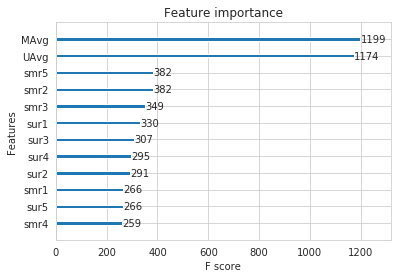

In [35]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=6, random_state=0, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

## Suprise BaselineModel [feature extraction]

### BaselineOnly

In [14]:
reg_test_df.shape, reg_train.shape

((7500, 16), (24995, 16))

__Predicted_rating : ( baseline prediction ) __

    -  http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly 
 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $


- $\pmb \mu $ : Average of all trainings in training data.
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases) 

**Optimization function ( Least Squares Problem )**

    - http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration 

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

#### BaselineOnly: learning_rate

In [9]:
Predictions = {}

In [10]:
best_train_results = None
best_test_results = None

best_rmse = 10

for lr in [0.0001,0.001,0.005,0.01,0.05,0.1]:
    # options are to specify.., how to compute those user and item biases
    bsl_options = {'method': 'sgd',
                   'learning_rate': lr
                   }
    bsl_algo = BaselineOnly(bsl_options=bsl_options)
    # run this algorithm.., It will return the train and test results..
    bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=False)


    # Just store these error metrics in our models_evaluation datastructure
    #models_evaluation_train['bsl_algo'] = bsl_train_results 
    #models_evaluation_test['bsl_algo'] = bsl_test_results
    
    print(f"lr: {lr} | train rmse: {bsl_train_results['rmse']} | test rmse: {bsl_test_results['rmse']}")
    if bsl_test_results['rmse'] < best_rmse:
        best_rmse = bsl_test_results['rmse']
        best_train_results = bsl_train_results
        best_test_results = bsl_test_results
Predictions['BaselineOnly'] = {'train':best_train_results['predictions'], 'test':best_test_results['predictions']}       

Estimating biases using sgd...
lr: 0.0001 | train rmse: 1.0275999220667338 | test rmse: 1.0579638429423854
Estimating biases using sgd...
lr: 0.001 | train rmse: 0.9772108316417094 | test rmse: 1.0287577135926278
Estimating biases using sgd...
lr: 0.005 | train rmse: 0.9130269563666398 | test rmse: 1.0064958124821288
Estimating biases using sgd...
lr: 0.01 | train rmse: 0.8868894084294947 | test rmse: 1.0157422697555896
Estimating biases using sgd...
lr: 0.05 | train rmse: 0.8584065779418889 | test rmse: 1.0816479621978392
Estimating biases using sgd...
lr: 0.1 | train rmse: 0.8700062581445566 | test rmse: 1.119520183848107


In [21]:
Predictions.keys()

dict_keys(['BaselineOnly'])

### XGBoost with initial 13 features + Surprise Baseline predictor 

In [85]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,10289,33,3.595311,5,4.0,1.0,1.0,1.0,4.0,5.0,4.0,5.0,4.0,3.800995,4.1875,4,4.097446
1,28423,33,3.595311,5,4.0,5.0,5.0,4.0,4.0,2.0,2.0,4.0,3.0,3.565934,4.1875,5,4.098766


In [86]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.412238
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.412238


Training the model..
Done. Time taken : 0:00:00.135019

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1522074576077612
MAPE :  38.108023368118516


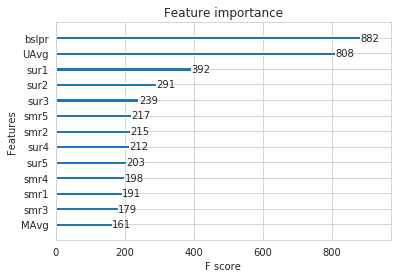

In [87]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()


### Surprise KNNBaseline predictor 

#### predicted Rating: based on User-User similarity



\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  _Baseline prediction_ of (user,movie) rating

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - __Similarity__ between users __u and v__  
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take base line predictions instead of mean rating of user/item)
       

- __ Predicted rating __ ( based on Item Item similarity ):
 \begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}

    -  ___Notations follows same as above (user user based predicted rating ) ___

Basiaclly It takes both rating difference weighted by user similarities and bias into account. This is equivalent to baseline+Knn+user-user sim

In [11]:
best_train_results = None
best_test_results = None

best_rmse = 10

for k in [30,40,50,100,150,250,500]:
    # we specify , how to compute similarities and what to consider with sim_options to our algorithm
    sim_options = {'user_based' : True,
                   'name': 'pearson_baseline',
                   'shrinkage': 100,
                   'min_support': 5
                  } 
    # we keep other parameters like regularization parameter and learning_rate as default values.
    bsl_options = {'method': 'sgd'} 

    knn_bsl_u = KNNBaseline(k=k, sim_options = sim_options, bsl_options = bsl_options)
    knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=False)

    # Just store these error metrics in our models_evaluation datastructure
#     models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
#     models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results
    
    print(f"k: {k} | train rmse: {knn_bsl_u_train_results['rmse']} | test rmse: {knn_bsl_u_test_results['rmse']}")
    if knn_bsl_u_test_results['rmse'] < best_rmse:
        best_rmse = knn_bsl_u_test_results['rmse']
        best_train_results = knn_bsl_u_train_results
        best_test_results = knn_bsl_u_test_results
Predictions['knn_bsl_u'] = {'train':best_train_results['predictions'], 'test':best_test_results['predictions']}       



Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
k: 30 | train rmse: 0.1915681290271953 | test rmse: 1.012330584642261
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
k: 40 | train rmse: 0.211705884500872 | test rmse: 1.0130112349078684
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
k: 50 | train rmse: 0.22671392115111605 | test rmse: 1.0127683969704797
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
k: 100 | train rmse: 0.2698488335442733 | test rmse: 1.0128491635389043
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
k: 150 | train rmse: 0.2917871705271838 | test rmse: 1.0125571388891859
Estimating biases using sgd...
Computing the pearson_baseli

#### predicted Rating: based on Movie-Movie similarity

In [12]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users


best_train_results = None
best_test_results = None

best_rmse = 10

for k in [30,40,50,100,150,250]:
    sim_options = {'user_based' : False,
                   'name': 'pearson_baseline',
                   'shrinkage': 100,
                   'min_support': 2
                  } 
    # we keep other parameters like regularization parameter and learning_rate as default values.
    bsl_options = {'method': 'sgd'}


    knn_bsl_m = KNNBaseline(k=k, sim_options = sim_options, bsl_options = bsl_options)

    knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=False)

    # Just store these error metrics in our models_evaluation datastructure
    #models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
    #models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results
    
    print(f"lr: {k} | train rmse: {knn_bsl_m_train_results['rmse']} | test rmse: {knn_bsl_m_test_results['rmse']}")
    if knn_bsl_m_test_results['rmse'] < best_rmse:
        best_rmse = knn_bsl_m_test_results['rmse']
        best_train_results = knn_bsl_m_train_results
        best_test_results = knn_bsl_m_test_results
Predictions['knn_bsl_m'] = {'train':best_train_results['predictions'], 'test':best_test_results['predictions']}       



Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
lr: 30 | train rmse: 0.1606744492114779 | test rmse: 1.0196269230965647
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
lr: 40 | train rmse: 0.16086060635345262 | test rmse: 1.0196269230965647
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
lr: 50 | train rmse: 0.16094107993663792 | test rmse: 1.0196269230965647
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
lr: 100 | train rmse: 0.1609851650065805 | test rmse: 1.0196269230965647
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
lr: 150 | train rmse: 0.1609851650065805 | test rmse: 1.0196269230965647
Estimating biases using sgd...
Computing the pearso

In [28]:
Predictions.keys()

dict_keys(['BaselineOnly', 'knn_bsl_u', 'knn_bsl_m'])

## Combined:  XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor

- - - First we will run XGBoost with predictions from both KNN's ( that uses User\_User and Item\_Item similarities along with our previous features.

 
- - - Then we will run XGBoost with just predictions form both knn models and preditions from our baseline model. 

### Train and Test data preparation

In [92]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,10289,33,3.595311,5,4.0,1.0,1.0,1.0,4.0,5.0,4.0,5.0,4.0,3.800995,4.1875,4,4.097446,4.000000,4.00000
1,28423,33,3.595311,5,4.0,5.0,5.0,4.0,4.0,2.0,2.0,4.0,3.0,3.565934,4.1875,5,4.098766,4.974326,4.99794


In [93]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.412238,3.412238,3.412238
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.412238,3.412238,3.412238


Training the model..
Done. Time taken : 0:00:00.115123

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.2125395035228455
MAPE :  41.48788082799595


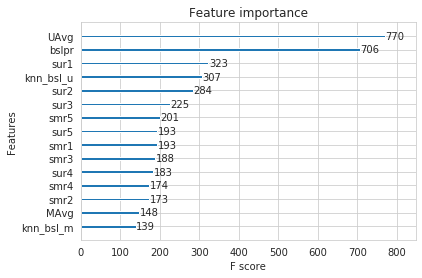

In [95]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

## Matrix Factorization Techniques

- __ Predicted Rating : __
    - 
    - $ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $
    
        - $\pmb q_i$ - Representation of item(movie) in latent factor space
        
        - $\pmb p_u$ - Representation of user in new latent factor space
        


- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [13]:
best_train_results = None
best_test_results = None

best_rmse = 10

for n_factors in [15,20,25,50, 100, 150,200,250]:
    # initiallize the model
    svd = SVD(n_factors=n_factors, biased=True, random_state=15, verbose=False)
    svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=False)

    # Just store thesfe error metrics in our models_evaluation datastructure
    #models_evaluation_train['svd'] = svd_train_results 
    #models_evaluation_test['svd'] = svd_test_results
    
    print(f"lr: {n_factors} | train rmse: {svd_train_results['rmse']} | test rmse: {svd_test_results['rmse']}")
    if svd_test_results['rmse'] < best_rmse:
        best_rmse = svd_test_results['rmse']
        best_train_results = svd_train_results
        best_test_results = svd_test_results
Predictions['svd'] = {'train':best_train_results['predictions'], 'test':best_test_results['predictions']}       


lr: 15 | train rmse: 0.8411050694995725 | test rmse: 1.005882971627073
lr: 20 | train rmse: 0.8289273347895793 | test rmse: 1.0112050964788908
lr: 25 | train rmse: 0.8060467236046566 | test rmse: 1.0073952923748517
lr: 50 | train rmse: 0.7353156029384903 | test rmse: 1.0082596213689448
lr: 100 | train rmse: 0.6511394424387283 | test rmse: 1.0129751912871334
lr: 150 | train rmse: 0.5894737492352261 | test rmse: 1.0044161337967055
lr: 200 | train rmse: 0.541199840628364 | test rmse: 1.0184151540254944
lr: 250 | train rmse: 0.5085849598778306 | test rmse: 1.006071732194645


In [36]:
Predictions.keys()

dict_keys(['BaselineOnly', 'knn_bsl_u', 'knn_bsl_m', 'svdpp', 'svd'])

### SVD Matrix Factorization with implicit feedback from user ( user rated movies )

- __ Predicted Rating : __
    - 
    - $ \large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $ 

 - $ \pmb{I_u}$ --- the set of all items rated by user u

- $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings.  

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ 

In [14]:
best_train_results = None
best_test_results = None

best_rmse = 10

for n_factors in [15,20,25,50, 100, 150,200,250]:
    # initiallize the model
    svdpp = SVDpp(n_factors=n_factors, random_state=15, verbose=False)
    svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=False)

    # Just store these error metrics in our models_evaluation datastructure
    #models_evaluation_train['svdpp'] = svdpp_train_results 
    #models_evaluation_test['svdpp'] = svdpp_test_results
    
    print(f"n_factors: {n_factors} | train rmse: {svdpp_train_results['rmse']} | test rmse: {svdpp_test_results['rmse']}")
    if svdpp_test_results['rmse'] < best_rmse:
        best_rmse = svdpp_test_results['rmse']
        best_train_results = svdpp_train_results
        best_test_results = svdpp_test_results
Predictions['svdpp'] = {'train':best_train_results['predictions'], 'test':best_test_results['predictions']}       



n_factors: 15 | train rmse: 0.6843840721162677 | test rmse: 1.0133952214267556
n_factors: 20 | train rmse: 0.6596254266291397 | test rmse: 1.0241829078345435
n_factors: 25 | train rmse: 0.63486295614693 | test rmse: 1.0124043848311413
n_factors: 50 | train rmse: 0.5537575692358078 | test rmse: 1.009118070520417
n_factors: 100 | train rmse: 0.4636546780354342 | test rmse: 1.023477888337705
n_factors: 150 | train rmse: 0.4108802512915235 | test rmse: 1.0077833468271582
n_factors: 200 | train rmse: 0.37584699904826036 | test rmse: 1.0194735668129467
n_factors: 250 | train rmse: 0.3528811049273938 | test rmse: 1.0071272748206854


### XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques (SVD and SVD ++)

In [105]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,10289,33,3.595311,5,4.0,1.0,1.0,1.0,4.0,5.0,...,5.0,4.0,3.800995,4.1875,4,4.097446,4.000000,4.00000,4.011051,4.165554
1,28423,33,3.595311,5,4.0,5.0,5.0,4.0,4.0,2.0,...,4.0,3.0,3.565934,4.1875,5,4.098766,4.974326,4.99794,4.564668,4.437838


In [106]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.412238,3.412238,3.412238,3.412238,3.412238
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.412238,3.412238,3.412238,3.412238,3.412238


Training the model..
Done. Time taken : 0:00:00.114707

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0747250799821615
MAPE :  35.246579981027956


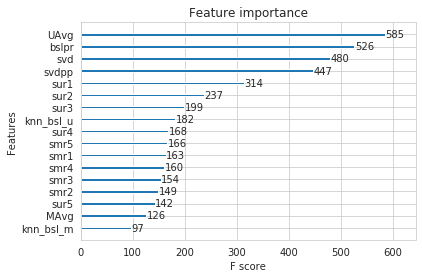

In [107]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

### XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques 

We will ignore initial hand crafted 13 features and consider only predictied outputs of indiuals models (remember these features supplement for those features) 

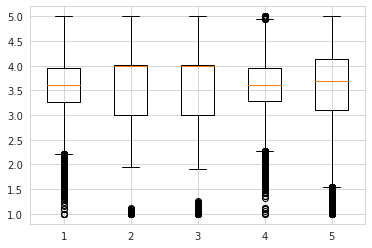

In [89]:
plt.boxplot(train.transpose());

In [126]:
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
50003,1415954,3827,3.588661,3.0,4.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.029412,3.818182,4
22474,1785209,3715,3.588661,4.0,3.0,4.0,3.0,5.0,2.0,4.0,5.0,5.0,5.0,3.465713,3.367115,2
317571,41031,9224,3.588661,3.0,4.0,4.0,3.0,2.0,4.0,4.0,4.0,3.0,5.0,3.752294,3.590090,4
41627,1703544,3824,3.588661,3.0,2.0,2.0,3.0,4.0,4.0,4.0,4.0,3.0,3.0,3.017378,3.491096,2
474919,1612701,12293,3.588661,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.303279,4.492073,5


In [15]:

train = reg_train[['GAvg','sur1','sur2','sur3','sur4','sur5','smr1','smr2','smr3','smr4','smr5','UAvg','MAvg']]
test = reg_test_df[['GAvg','sur1','sur2','sur3','sur4','sur5','smr1','smr2','smr3','smr4','smr5','UAvg','MAvg']]


keys = list(Predictions.keys())
#keys.remove('BaselineOnly')


for key in keys:
    train[key] = Predictions[key]['train']
    test[key] = Predictions[key]['test']
    
# prepare train data
x_train = train
y_train = reg_train['rating']

# test data
x_test = test
y_test = reg_test_df['rating']

ind = int(len(x_train)*0.8)

x_train, y_train, x_valid, y_valid = train[:ind], reg_train['rating'][:ind], train[ind:], reg_train['rating'][ind:]



/home/skumar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/skumar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [16]:

param_grid = {
    "n_estimators": [100, 150, 250],
    "learning_rate": [0.01,0.05, 0.10, 0.15],
    "max_depth": [3, 4, 5, 6, 8],
    "min_child_weight": [1, 3, 5],
    "gamma": [0.0, 0.1, 0.2],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
    'eta': [0.1, 0.2, 0.3]
}

param_list = [dict(zip(param_grid, v)) for v in product(*param_grid.values())]


best_rmse = 10
best_model = None

for i,params in enumerate(tqdm(param_list)):
    model = XGBRegressor(**params)
    model.fit(x_train, y_train) 
    rmse = sqrt(mean_squared_error(y_valid, model.predict(x_valid)))
    
    if rmse < best_rmse:
        print(f'{i}th iter found best model with rmse {rmse}')
        best_rmse = rmse 
        best_model = model
        best_params = params
best_model.fit(train,reg_train['rating'].values());

0th iter found best model with rmse 1.486933381717499
3th iter found best model with rmse 1.4819735263653186



KeyboardInterrupt: 

In [21]:
best_params, best_rmse

({'n_estimators': 250,
  'learning_rate': 0.05,
  'max_depth': 6,
  'min_child_weight': 3,
  'gamma': 0.2,
  'colsample_bytree': 0.3,
  'eta': 0.1},
 0.9026202452356218)

In [22]:
sqrt(mean_squared_error(y_test, model.predict(x_test)))

0.9675924281609322

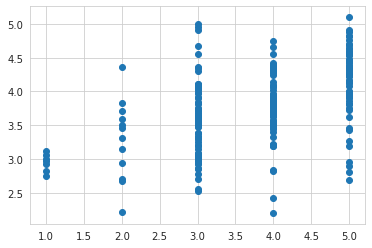

In [27]:
plt.scatter(y_test, model.predict(x_test))

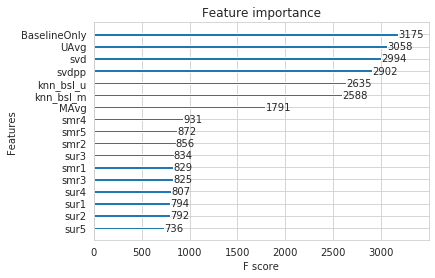

In [23]:
import xgboost as xgb
xgb.plot_importance(model)
plt.show()

### Comparision between all models

In [110]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('small_sample_results.csv')
models = pd.read_csv('small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

xgb_final         1.0747250799821615
knn_bsl_u         1.0885052505724113
knn_bsl_m         1.0885052505724113
svdpp             1.0885116029501927
svd               1.0885255090952508
bsl_algo          1.0886002730558602
xgb_all_models     1.100734718659086
first_algo        1.1200760907657852
xgb_bsl           1.1522074576077612
xgb_knn_bsl       1.2125395035228455
Name: rmse, dtype: object

In [111]:
print("-"*100)
print("Total time taken to run this entire notebook ( with saved files) is :",datetime.now()-globalstart)

----------------------------------------------------------------------------------------------------


NameError: name 'globalstart' is not defined